In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define constants
SR = 4000  # Sampling rate
DURATION = 15  # Duration to load in seconds
MAX_LEN = SR * DURATION  # Maximum length of the signal
WINDOW_SIZE = 0.5  # Window size for energy computation in seconds
ENERGY_THRESHOLD = 0.01  # Threshold for energy to detect murmur

In [ ]:
# ------------------------
# Bandpass filter to isolate heart sounds (20–200 Hz)
# ------------------------
def bandpass_filter(signal, sr, lowcut=20, highcut=200):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [ ]:
# ------------------------
# Compute short-term energy to identify murmur regions
# ------------------------
def compute_energy(signal, sr, window_sec):
    window_size = int(sr * window_sec)
    energy = np.array([
        np.sum(np.square(signal[i:i+window_size]))
        for i in range(0, len(signal) - window_size, window_size)
    ])
    return energy


In [ ]:
# ------------------------
# Plot and optionally extract murmur part
# ------------------------
def plot_and_extract_murmur(signal, sr, label):
    signal = bandpass_filter(signal, sr)
    energy = compute_energy(signal, sr, WINDOW_SIZE)
    times = np.arange(len(energy)) * WINDOW_SIZE

    plt.figure(figsize=(10, 4))
    plt.plot(times, energy, label='Energy')
    plt.axhline(ENERGY_THRESHOLD, color='r', linestyle='--', label='Threshold')
    plt.title(f"Murmur Detection - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Detect murmur indices
    murmur_idx = np.where(energy > ENERGY_THRESHOLD)[0]
    if len(murmur_idx) == 0:
        print("No murmur detected.")
        return None

    # Get time bounds of murmur
    start_sample = int(murmur_idx[0] * SR * WINDOW_SIZE)
    end_sample = int((murmur_idx[-1] + 1) * SR * WINDOW_SIZE)
    murmur_segment = signal[start_sample:end_sample]

    print(f"Murmur segment: {start_sample/SR:.2f}s to {end_sample/SR:.2f}s")
    return murmur_segment

In [ ]:
# ------------------------
# Load and compare samples
# ------------------------
def load_and_compare(normal_path, murmur_path):
    # Load signals
    normal, _ = librosa.load(normal_path, sr=SR, duration=DURATION)
    murmur, _ = librosa.load(murmur_path, sr=SR, duration=DURATION)

    # Pad or trim
    normal = np.pad(normal, (0, max(0, MAX_LEN - len(normal))))[:MAX_LEN]
    murmur = np.pad(murmur, (0, max(0, MAX_LEN - len(murmur))))[:MAX_LEN]

    # Plot both
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(normal)
    plt.title("Normal PCG")
    plt.xlabel("Samples")
    plt.subplot(1, 2, 2)
    plt.plot(murmur)
    plt.title("Murmur PCG")
    plt.xlabel("Samples")
    plt.tight_layout()
    plt.show()

    # Murmur detection
    murmur_cut = plot_and_extract_murmur(murmur, SR, label="Abnormal")
    return murmur_cut

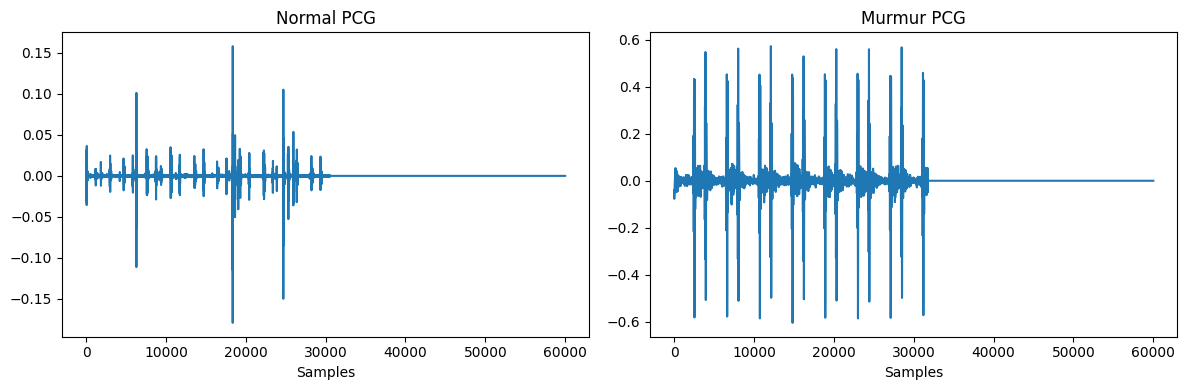

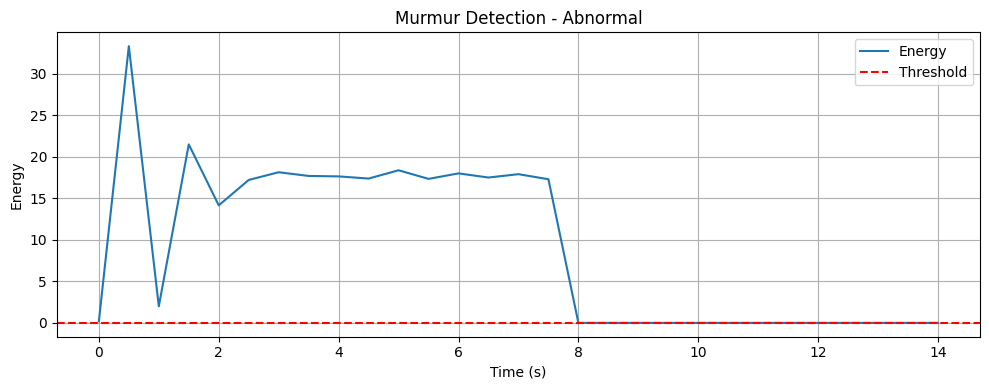

Murmur segment: 0.00s to 8.00s


In [ ]:
# Example usage:
import soundfile as sf

murmur_part = load_and_compare("/content/drive/MyDrive/TMSL_30_6_25/input/set_a/normal__201104141251.wav",
                               "/content/drive/MyDrive/TMSL_30_6_25/input/set_a/murmur__201108222236.wav")
sf.write("extracted_murmur.wav", murmur_part, SR)  # Save if needed

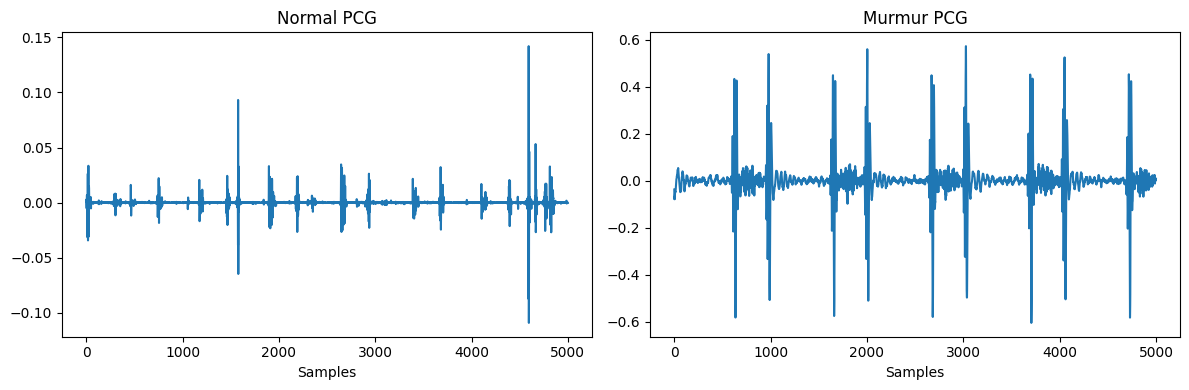

Murmur segment: 0.00s to 4.80s


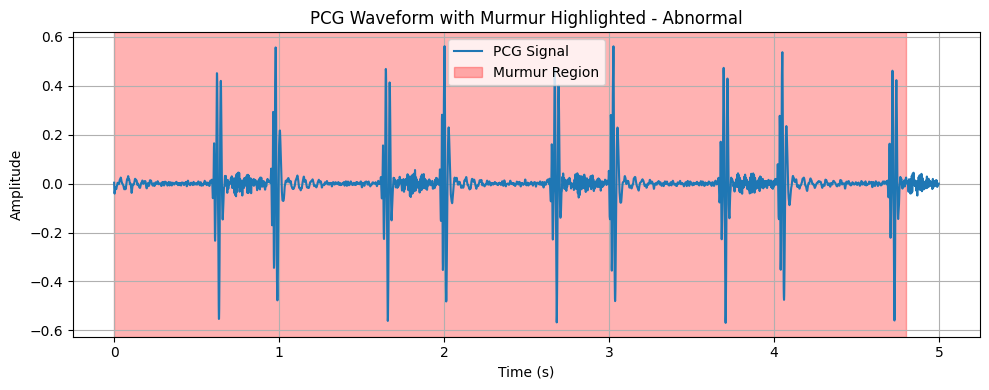

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ------------------------
# Parameters
# ------------------------
SR = 1000               # Sampling rate
DURATION = 5            # Max audio length in seconds
MAX_LEN = SR * DURATION
ENERGY_THRESHOLD = 0.01 # Empirical threshold to detect murmur
WINDOW_SIZE = 0.2       # Seconds

# ------------------------
# Bandpass filter to isolate heart sounds (20–200 Hz)
# ------------------------
def bandpass_filter(signal, sr, lowcut=20, highcut=200):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, signal)

# ------------------------
# Compute short-term energy to identify murmur regions
# ------------------------
def compute_energy(signal, sr, window_sec):
    window_size = int(sr * window_sec)
    energy = np.array([
        np.sum(np.square(signal[i:i+window_size]))
        for i in range(0, len(signal) - window_size, window_size)
    ])
    return energy

# ------------------------
# Plot and optionally extract murmur part
# ------------------------
def plot_and_extract_murmur(signal, sr, label):
    signal = bandpass_filter(signal, sr)
    energy = compute_energy(signal, sr, WINDOW_SIZE)
    times = np.arange(len(energy)) * WINDOW_SIZE

    # Detect murmur indices
    murmur_idx = np.where(energy > ENERGY_THRESHOLD)[0]
    if len(murmur_idx) == 0:
        print("No murmur detected.")
        return None

    # Get time bounds of murmur
    start_sample = int(murmur_idx[0] * SR * WINDOW_SIZE)
    end_sample = int((murmur_idx[-1] + 1) * SR * WINDOW_SIZE)
    murmur_segment = signal[start_sample:end_sample]

    print(f"Murmur segment: {start_sample/SR:.2f}s to {end_sample/SR:.2f}s")

    # Plot waveform with murmur region highlighted
    t = np.arange(len(signal)) / SR
    plt.figure(figsize=(10, 4))
    plt.plot(t, signal, label="PCG Signal")
    plt.axvspan(start_sample / SR, end_sample / SR, color='red', alpha=0.3, label="Murmur Region")
    plt.title(f"PCG Waveform with Murmur Highlighted - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return murmur_segment

# ------------------------
# Load and compare samples
# ------------------------
def load_and_compare(normal_path, murmur_path):
    # Load signals
    normal, _ = librosa.load(normal_path, sr=SR, duration=DURATION)
    murmur, _ = librosa.load(murmur_path, sr=SR, duration=DURATION)

    # Pad or trim
    normal = np.pad(normal, (0, max(0, MAX_LEN - len(normal))))[:MAX_LEN]
    murmur = np.pad(murmur, (0, max(0, MAX_LEN - len(murmur))))[:MAX_LEN]

    # Plot both
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(normal)
    plt.title("Normal PCG")
    plt.xlabel("Samples")
    plt.subplot(1, 2, 2)
    plt.plot(murmur)
    plt.title("Murmur PCG")
    plt.xlabel("Samples")
    plt.tight_layout()
    plt.show()

    # Murmur detection
    murmur_cut = plot_and_extract_murmur(murmur, SR, label="Abnormal")
    return murmur_cut

# Example usage:
murmur_part = load_and_compare("/content/drive/MyDrive/TMSL_30_6_25/input/set_a/normal__201104141251.wav",
                               "/content/drive/MyDrive/TMSL_30_6_25/input/set_a/murmur__201108222236.wav")
sf.write("extracted_murmur.wav", murmur_part, SR)  # Save if needed


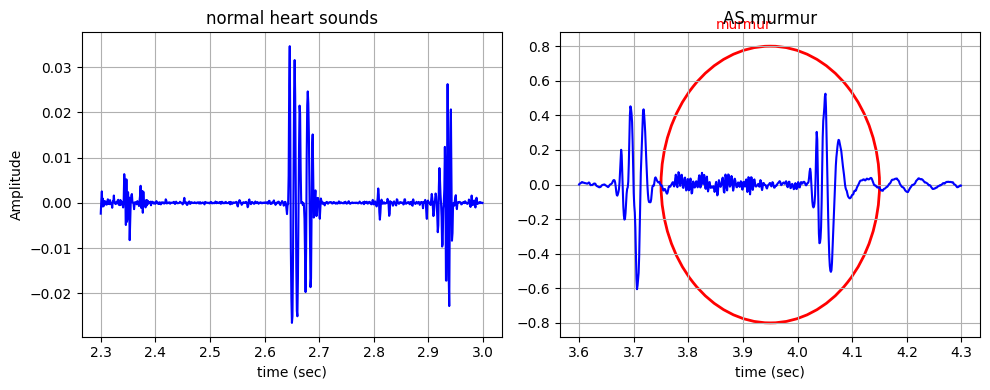

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Load signals (example: 5s duration)
SR = 1000
normal_file = "/content/drive/MyDrive/TMSL_30_6_25/input/set_a/normal__201104141251.wav"
#murmur_file = "aortic_stenosis_001.wav"
murmur_file="/content/drive/MyDrive/TMSL_30_6_25/input/set_a/murmur__201108222236.wav"

normal, _ = librosa.load(normal_file, sr=SR, duration=5)
murmur, _ = librosa.load(murmur_file, sr=SR, duration=5)

# Time axis
t_normal = np.arange(len(normal)) / SR
t_murmur = np.arange(len(murmur)) / SR

# Extract small segment from both for zoomed view
normal_segment = normal[int(2.3*SR):int(3.0*SR)]
t_norm_seg = t_normal[int(2.3*SR):int(3.0*SR)]

murmur_segment = murmur[int(3.6*SR):int(4.3*SR)]
t_murm_seg = t_murmur[int(3.6*SR):int(4.3*SR)]

# Plot
plt.figure(figsize=(10, 4))

# Plot normal heart sound
plt.subplot(1, 2, 1)
plt.plot(t_norm_seg, normal_segment, color='blue')
plt.title("normal heart sounds")
plt.xlabel("time (sec)")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot murmur sound
plt.subplot(1, 2, 2)
plt.plot(t_murm_seg, murmur_segment, color='blue')
plt.title("AS murmur")
plt.xlabel("time (sec)")
plt.grid(True)

# Add murmur ellipse annotation
ellipse = Ellipse(xy=(3.95, 0), width=0.4, height=1.6,
                  edgecolor='red', facecolor='none', lw=2)
plt.gca().add_patch(ellipse)
plt.text(3.85, 0.9, "murmur", color='red', fontsize=10)

plt.tight_layout()
plt.show()


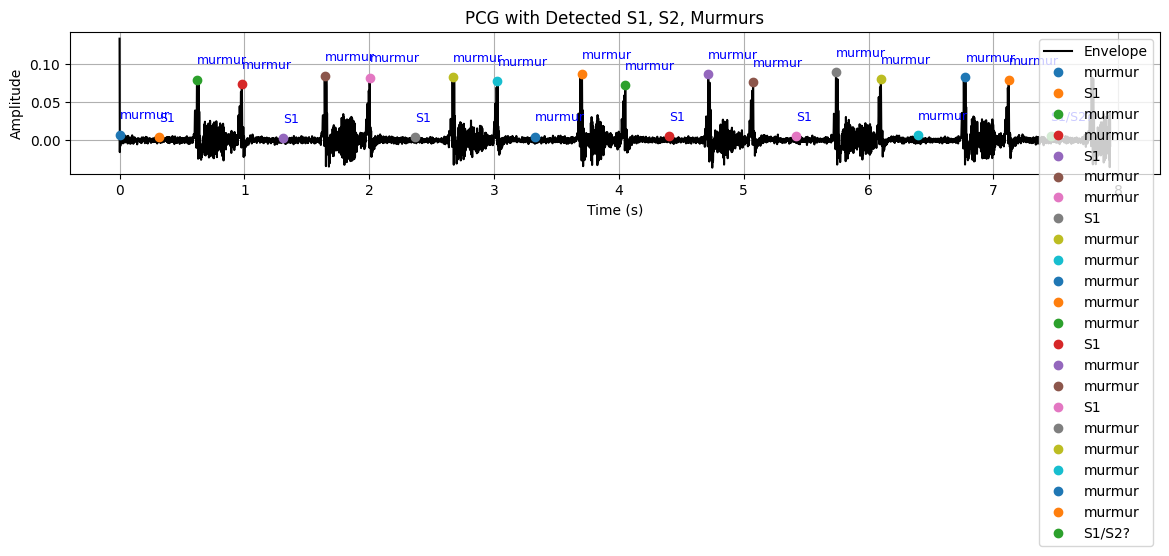

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, hilbert # Import hilbert from scipy.signal

# Load PCG signal
file = "/content/drive/MyDrive/TMSL_30_6_25/input/set_a/murmur__201108222236.wav"
SR = 1000
signal, _ = librosa.load(file, sr=SR)
duration = len(signal) / SR
time = np.linspace(0, duration, len(signal))

# Compute envelope using Hilbert transform
envelope = np.abs(hilbert(signal)) # Use hilbert from scipy.signal

# Smooth envelope to remove noise
smoothed = librosa.effects.preemphasis(envelope)

# Peak detection (S1/S2 candidates)
peaks, _ = find_peaks(smoothed, distance=SR*0.3, height=np.mean(smoothed))

# Annotate peaks
labels = []
for i in range(len(peaks) - 1):
    d1 = peaks[i+1] - peaks[i] # Interval after current peak
    if i + 2 < len(peaks): # Check if there is a next interval
        d2 = peaks[i+2] - peaks[i+1] # Next interval

        f1 = smoothed[peaks[i]]
        f2 = smoothed[peaks[i+1]]

        if d1 < d2 and f1 < f2:
            labels.append("S1")
        elif d2 > d1 and f2 > f1:
            labels.append("S2")
        else:
            labels.append("murmur")
    else:
        # Handle the last peak where there's no next interval to compare
        labels.append("S1/S2?") # Or some other appropriate label

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(time, smoothed, label="Envelope", color="black")
for i, peak in enumerate(peaks[:-1]):
    label = labels[i]
    plt.plot(time[peak], smoothed[peak], 'o', label=label)
    plt.text(time[peak], smoothed[peak] + 0.02, label, color='blue', fontsize=9)


plt.title("PCG with Detected S1, S2, Murmurs")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

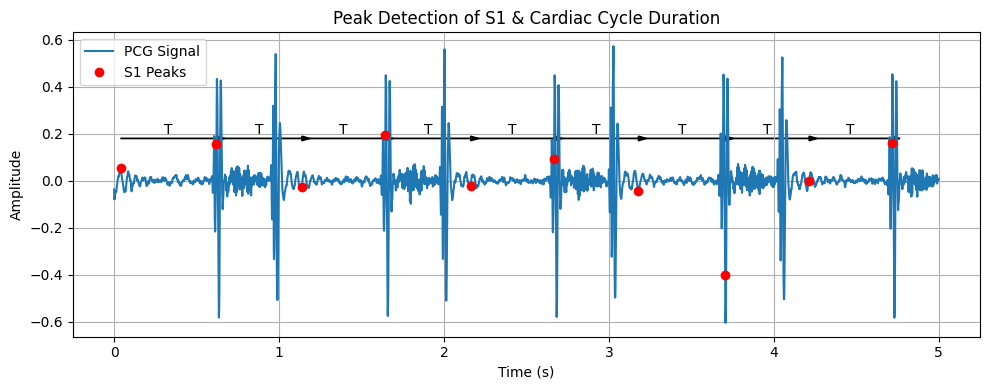

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, hilbert # Import hilbert from scipy.signal

# Load the PCG signal
file = "/content/drive/MyDrive/TMSL_30_6_25/input/set_a/murmur__201108222236.wav"  # replace with your file
SR = 1000
signal, _ = librosa.load(file, sr=SR, duration=5)
time = np.linspace(0, len(signal)/SR, len(signal))

# Envelope for better peak detection
envelope = np.abs(hilbert(signal))
smoothed = librosa.effects.preemphasis(envelope)

# Detect peaks as S1 candidates
peaks, _ = find_peaks(smoothed, height=np.mean(smoothed), distance=SR * 0.5)

# Calculate cardiac cycle durations (time between peaks)
cycle_times = np.diff(peaks) / SR  # in seconds

# Plot signal with S1 peak annotations
plt.figure(figsize=(10, 4))
plt.plot(time, signal, label='PCG Signal')
plt.plot(time[peaks], signal[peaks], 'ro', label='S1 Peaks')

# Annotate peak positions and cycle durations
for i in range(len(peaks)-1):
    t1 = time[peaks[i]]
    t2 = time[peaks[i+1]]
    T = t2 - t1
    plt.annotate("T", xy=((t1 + t2)/2, 0.2), ha='center', color='black', fontsize=10)
    plt.arrow(t1, 0.18, T, 0, head_width=0.02, head_length=0.05, fc='black', ec='black')

# Labeling
plt.title("Peak Detection of S1 & Cardiac Cycle Duration")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()